In [7]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息
plt.rcParams['font.sans-serif'] = 'SimHei'  # 中文黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 读取数据
df = pd.read_csv(
    r"C:\Users\le\Desktop\数据分析\cleaned_source.csv",
    skiprows=2,
    header=None,
    names=[
        "CustomerID", "Age", "Gender", "Tenure",
        "Usage Frequency", "Support Calls", "Payment Delay",
        "Subscription Type", "Contract Length", "Total Spend",
        "Last Interact", "Churn"
    ]
)

# 确保 Age 列是字符串类型
df["Age"] = df["Age"].astype(str)

# 拆分合并字段
# 拆分前先检查是否有足够的分隔符
split_result = df["Age"].str.split(" ", n=1, expand=True)

# 确保拆分后的结果总是有两列
split_result = split_result.reindex(columns=[0, 1], fill_value="Unknown")
split_result.columns = ["Age", "Gender"]  # 设置列名

# 更新原始 DataFrame
df[["Age", "Gender"]] = split_result

# 将 Age 和 Payment Delay 转换为整数类型
df["Age"] = pd.to_numeric(df["Age"], errors='coerce')  # 转换失败的值将变为 NaN
df["Age"].fillna(df["Age"].median(), inplace=True)  # 用中位数填充 NaN
df["Payment Delay"] = df["Payment Delay"].astype(int)

# 删除多余列
df = df.iloc[:, 0:12]

# 缺失值处理
df.dropna(subset=["Payment Delay"], inplace=True)
df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)
df["Last Interact"].fillna(df["Last Interact"].median(), inplace=True)

# 异常值处理
upper_limit = df["Total Spend"].quantile(0.99)
df["Total Spend"] = np.where(df["Total Spend"] > upper_limit, upper_limit, df["Total Spend"])
# 统计流失用户
churned_users = df[df["Churn"] == 1]
print(f"流失用户数量：{len(churned_users)}")

# 保存数据
df.to_csv("final_cleaned_data.csv", index=False)
print("预处理完成！")


流失用户数量：30492
预处理完成！


In [ ]:
#可视化部分

数据加载成功！记录数: 64373


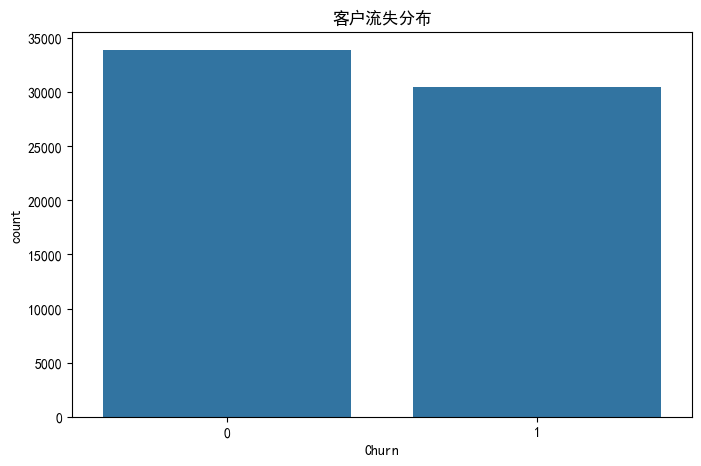

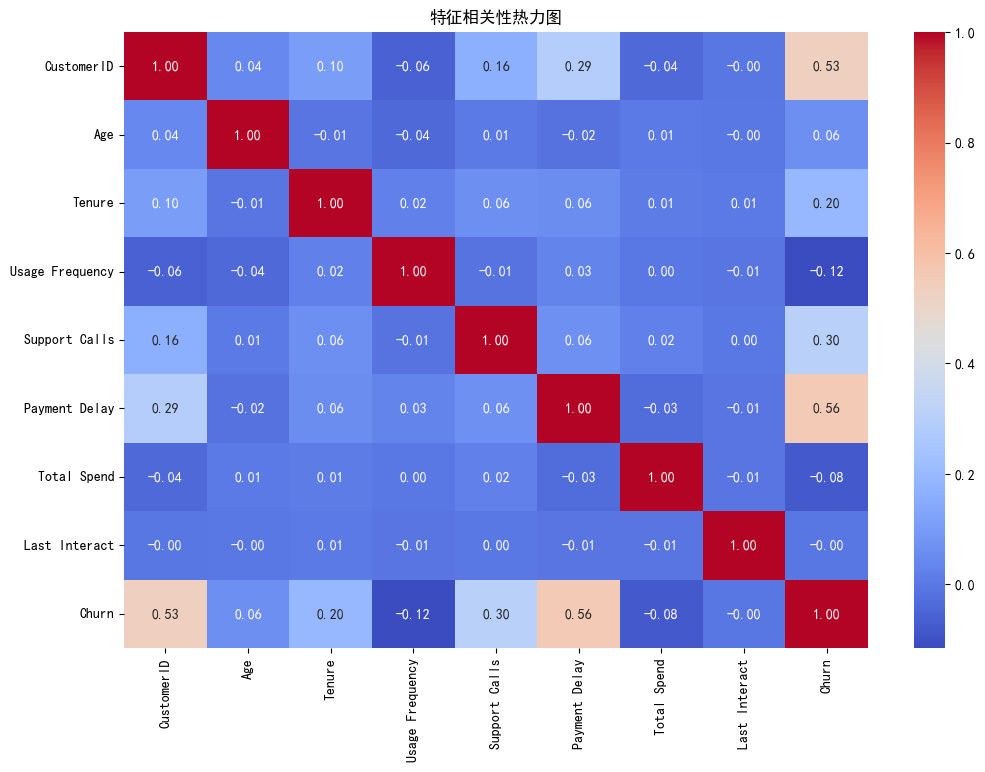

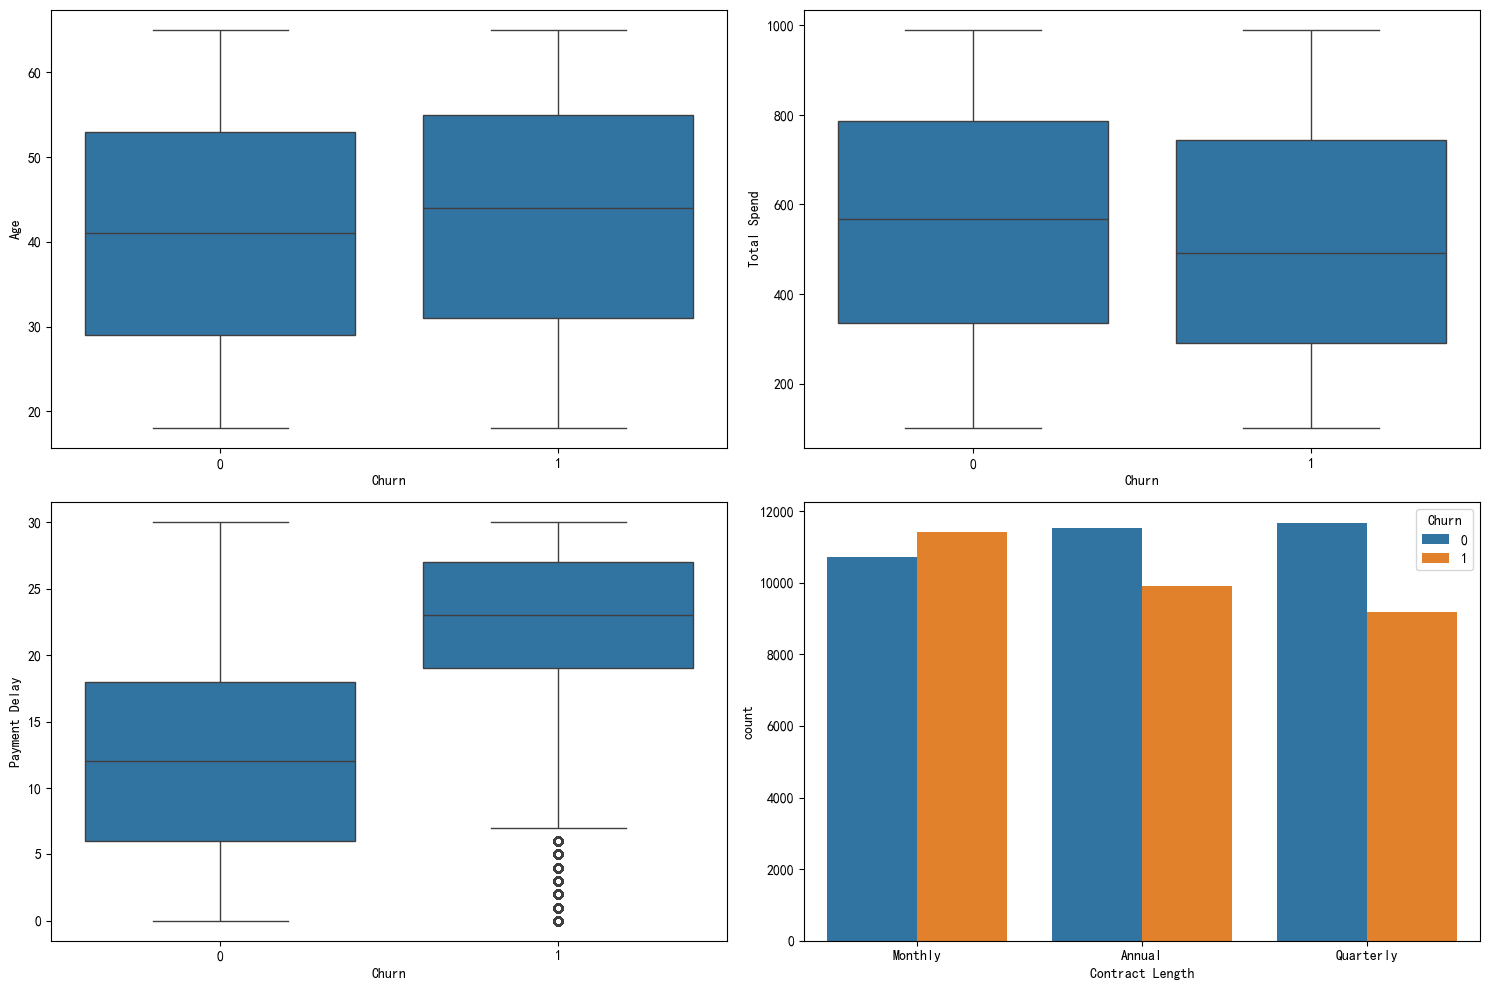

所有图表生成完成！


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 加载清洗后的数据
try:
    df = pd.read_csv("final_cleaned_data.csv")
    print("数据加载成功！记录数:", len(df))
except FileNotFoundError:
    print("错误：final_cleaned_data.csv 文件不存在")
    exit()

# 2. 整体流失情况分析
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df)
plt.title('客户流失分布')
plt.savefig('churn_distribution.png', dpi=300)
plt.show()

# 3. 特征相关性分析（仅数值列）
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12, 8))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('特征相关性热力图')
plt.savefig('corr_heatmap.png', dpi=300)
plt.show()

# 4. 关键特征分布分析
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 检查列是否存在
if 'Age' in df.columns:
    sns.boxplot(x='Churn', y='Age', data=df, ax=axes[0, 0])
else:
    print("警告：'Age' 列不存在")

if 'Total Spend' in df.columns:
    sns.boxplot(x='Churn', y='Total Spend', data=df, ax=axes[0, 1])
else:
    print("警告：'Total Spend' 列不存在")

if 'Payment Delay' in df.columns:
    sns.boxplot(x='Churn', y='Payment Delay', data=df, ax=axes[1, 0])
else:
    print("警告：'Payment Delay' 列不存在")

if 'Contract Length' in df.columns:
    sns.countplot(x='Contract Length', hue='Churn', data=df, ax=axes[1, 1])
else:
    print("警告：'Contract Length' 列不存在")

plt.tight_layout()
plt.savefig('feature_distribution.png', dpi=300)
plt.show()

print("所有图表生成完成！")

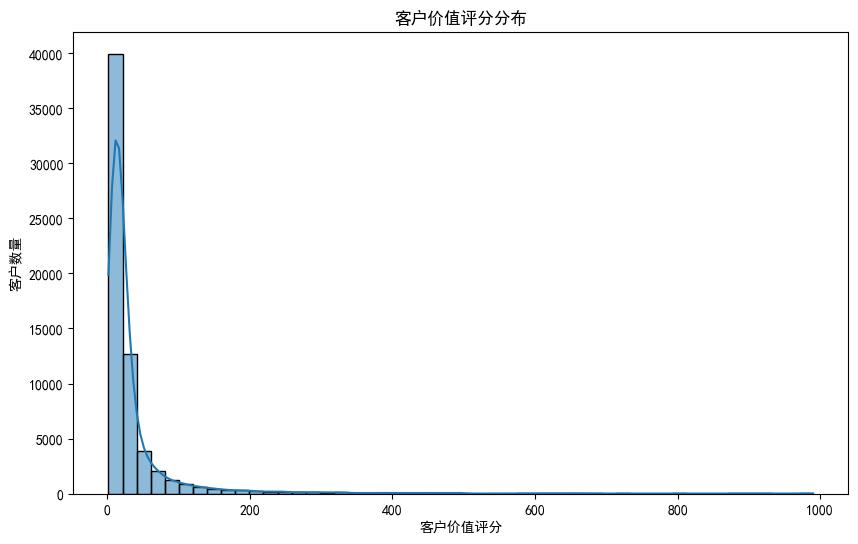

In [9]:
# 计算客户价值评分
df['Customer Value Score'] = df['Total Spend'] / df['Tenure']

# 处理无穷大值（使用时长Tenure为0的情况）
df.loc[df['Tenure'] == 0, 'Customer Value Score'] = df['Total Spend']

# 可视化客户价值评分分布
plt.figure(figsize=(10, 6))
sns.histplot(df['Customer Value Score'], bins=50, kde=True)
plt.title('客户价值评分分布')
plt.xlabel('客户价值评分')
plt.ylabel('客户数量')
plt.savefig('customer_value_distribution.png', dpi=300)
plt.show()

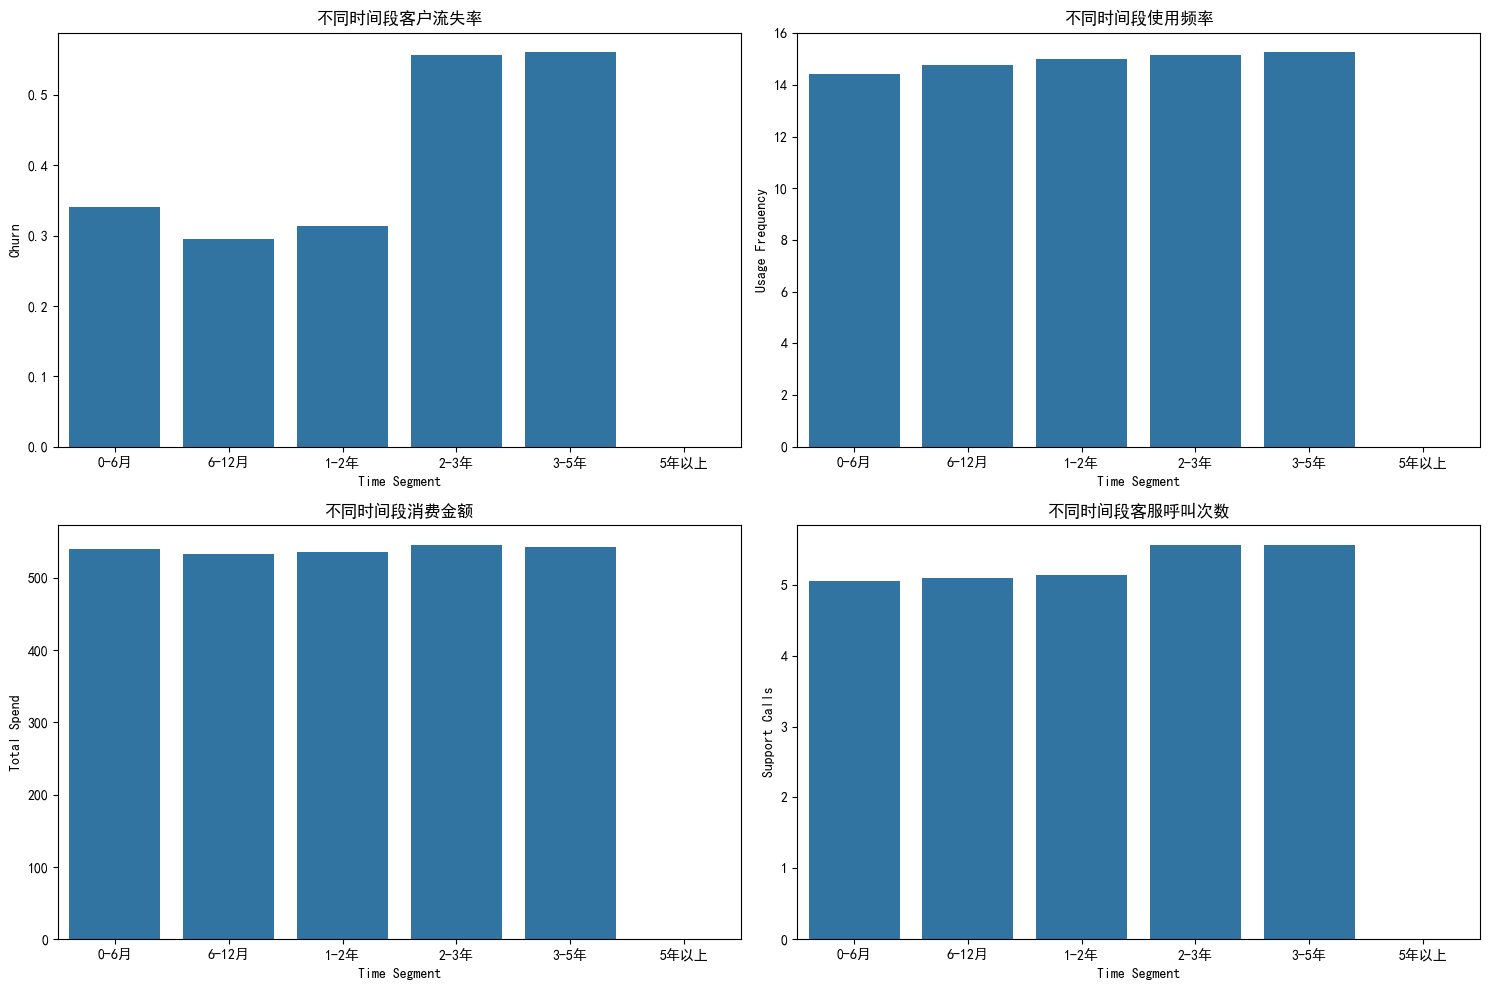

In [10]:
# 创建时间序列特征（假设数据中有时间戳列）
# 如果没有，可以使用Tenure作为时间代理
df['Time Segment'] = pd.cut(df['Tenure'], 
                           bins=[0, 6, 12, 24, 36, 60, 120],
                           labels=['0-6月', '6-12月', '1-2年', '2-3年', '3-5年', '5年以上'])

# 分析不同时间段内的客户行为变化
time_analysis = df.groupby('Time Segment').agg({
    'Churn': 'mean',
    'Usage Frequency': 'mean',
    'Total Spend': 'mean',
    'Support Calls': 'mean'
}).reset_index()

# 可视化时间序列变化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='Time Segment', y='Churn', data=time_analysis, ax=axes[0, 0])
axes[0, 0].set_title('不同时间段客户流失率')

sns.barplot(x='Time Segment', y='Usage Frequency', data=time_analysis, ax=axes[0, 1])
axes[0, 1].set_title('不同时间段使用频率')

sns.barplot(x='Time Segment', y='Total Spend', data=time_analysis, ax=axes[1, 0])
axes[1, 0].set_title('不同时间段消费金额')

sns.barplot(x='Time Segment', y='Support Calls', data=time_analysis, ax=axes[1, 1])
axes[1, 1].set_title('不同时间段客服呼叫次数')

plt.tight_layout()
plt.savefig('time_series_analysis.png', dpi=300)
plt.show()

In [ ]:
#模型处理部分


Logistic Regression 模型性能:
ROC AUC: 0.8925
F1 Score: 0.8111
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      6776
           1       0.79      0.84      0.81      6099

    accuracy                           0.82     12875
   macro avg       0.82      0.82      0.82     12875
weighted avg       0.82      0.82      0.82     12875


Random Forest 模型性能:
ROC AUC: 0.9881
F1 Score: 0.9483
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      6776
           1       0.91      0.99      0.95      6099

    accuracy                           0.95     12875
   macro avg       0.95      0.95      0.95     12875
weighted avg       0.95      0.95      0.95     12875


XGBoost 模型性能:
ROC AUC: 0.9893
F1 Score: 0.9486
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      6776
           1       0.91      0.99      0.95      6099

    accuracy        

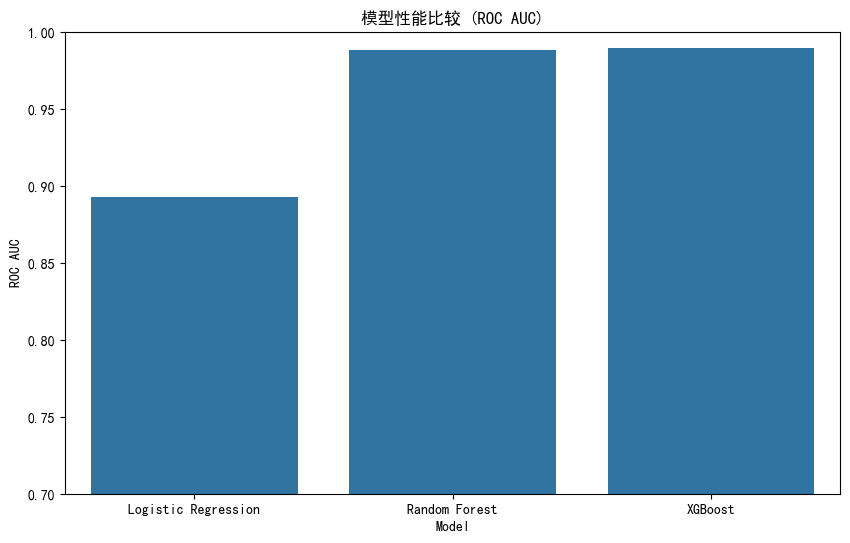

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# 准备特征和目标变量
X = df.drop(['CustomerID', 'Churn', 'Time Segment'], axis=1)
y = df['Churn']

# 转换分类变量
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 标准化数值特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), 
                            eval_metric='logloss', random_state=42)
}

# 训练并评估模型
results = {}
for name, model in models.items():
    # 创建包含SMOTE的管道
    pipeline = make_pipeline(
        SMOTE(random_state=42),
        model
    )
    
    # 训练模型
    pipeline.fit(X_train_scaled, y_train)
    
    # 预测
    y_pred = pipeline.predict(X_test_scaled)
    y_prob = pipeline.predict_proba(X_test_scaled)[:, 1]
    
    # 评估
    results[name] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'f1_score': f1_score(y_test, y_pred),
        'model': pipeline
    }
    
    print(f"\n{name} 模型性能:")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {results[name]['f1_score']:.4f}")
    print(classification_report(y_test, y_pred))

# 比较模型性能
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC AUC': [results[m]['roc_auc'] for m in results],
    'F1 Score': [results[m]['f1_score'] for m in results]
})

# 可视化模型比较
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC AUC', data=model_comparison)
plt.title('模型性能比较 (ROC AUC)')
plt.ylim(0.7, 1.0)
plt.savefig('model_comparison_auc.png', dpi=300)
plt.show()

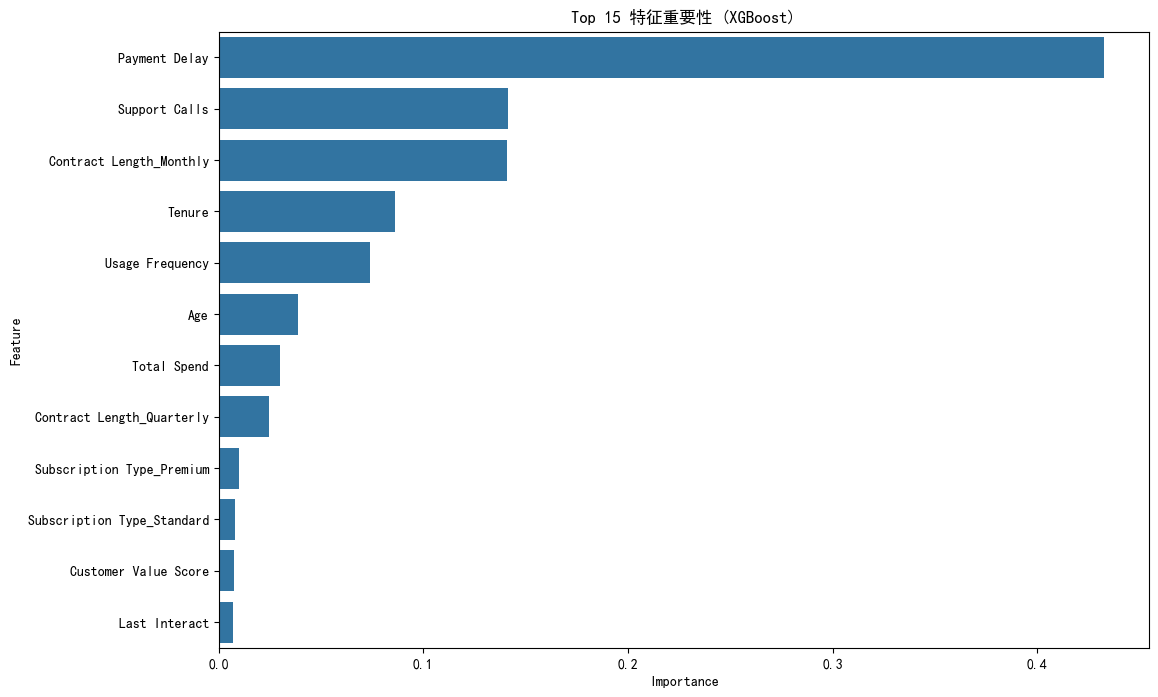

In [12]:
# 获取最佳模型的特征重要性
best_model = results['XGBoost']['model'].named_steps['xgbclassifier']

# 获取特征重要性
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 特征重要性 (XGBoost)')
plt.savefig('feature_importance.png', dpi=300)
plt.show()

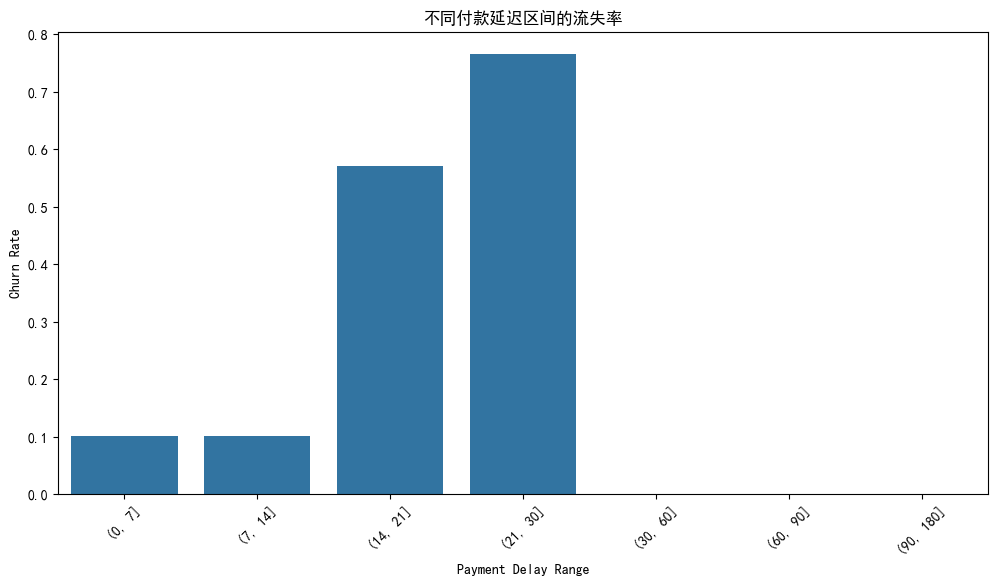


付款延迟预警机制建议:
1. 设置多级预警系统：
   - 延迟7天：自动发送短信提醒
   - 延迟14天：人工客服电话提醒
   - 延迟21天：提供小额优惠券激励及时付款
   - 延迟30天以上：高级客服介入，提供分期付款选项
2. 针对高风险客户提供自动支付选项
3. 为历史付款记录良好的客户提供宽限期


In [13]:
# 分析付款延迟与流失的关系
payment_delay_analysis = df.groupby(pd.cut(df['Payment Delay'], 
                                         bins=[0, 7, 14, 21, 30, 60, 90, 180])).agg({
    'Churn': ['mean', 'count']
}).reset_index()

payment_delay_analysis.columns = ['Payment Delay Range', 'Churn Rate', 'Customer Count']

# 可视化
plt.figure(figsize=(12, 6))
sns.barplot(x='Payment Delay Range', y='Churn Rate', data=payment_delay_analysis)
plt.title('不同付款延迟区间的流失率')
plt.xticks(rotation=45)
plt.savefig('payment_delay_churn.png', dpi=300)
plt.show()

# 预警机制建议
print("\n付款延迟预警机制建议:")
print("1. 设置多级预警系统：")
print("   - 延迟7天：自动发送短信提醒")
print("   - 延迟14天：人工客服电话提醒")
print("   - 延迟21天：提供小额优惠券激励及时付款")
print("   - 延迟30天以上：高级客服介入，提供分期付款选项")
print("2. 针对高风险客户提供自动支付选项")
print("3. 为历史付款记录良好的客户提供宽限期")

In [43]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 安全加载数据的函数
def load_data(file_path):
    try:
        df = pd.read_csv("final_cleaned_data.csv")
        print(f"数据加载成功，共{len(df)}行，{len(df.columns)}列")
        print(f"数据集行数: {len(df)}, 列数: {len(df.columns)}")
        print("数据基本信息：")
        df.info()
        return df
    except FileNotFoundError:
        print(f"错误：文件 '{file_path}' 不存在，请检查路径")
        return None
    except Exception as e:
        print(f"加载文件时发生未知错误: {e}")
        return None

# 加载数据
df = load_data("final_cleaned_data.csv")

# 仅在数据成功加载时执行后续分析
if df is not None:
    # 确认关键列存在
    required_columns = ['Churn', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"错误：数据集中缺少必要的列: {missing_columns}")
    else:
        # 准备特征和目标变量
        X = df.drop(['Churn'], axis=1)
        y = df['Churn']
        
        # 区分数值特征和分类特征
        numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        
        print("\n数值特征:", numerical_features)
        print("分类特征:", categorical_features)
        
        # 创建预处理管道
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])
        
        # 创建完整的模型管道
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=42))
        ])
        
        # 训练模型
        print("\n正在训练模型...")
        model.fit(X, y)
        
        # 获取特征重要性
        ohe = model.named_steps['preprocessor'].named_transformers_['cat']
        feature_names = numerical_features + list(ohe.get_feature_names_out(categorical_features))
        
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.named_steps['classifier'].feature_importances_
        })
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
        
        # 识别高流失风险客户特征
        high_risk_features = feature_importance.head(5)['Feature'].tolist()
        print("\n高流失风险特征:")
        print(feature_importance.head(5))
        
        # 分析高流失风险客户特征
        high_risk_analysis = {}
        for feature in high_risk_features:
            # 对于独热编码后的特征，找到原始特征名
            original_feature = feature.split('_')[0] if '_' in feature else feature
            
            if original_feature in numerical_features:
                # 数值特征分析
                high_risk_analysis[feature] = df.groupby(pd.qcut(df[original_feature], 5)).agg({
                    'Churn': 'mean'
                })
            else:
                # 分类特征分析
                high_risk_analysis[feature] = df.groupby(original_feature).agg({
                    'Churn': 'mean'
                })
            
            print(f"\n{feature} 与流失率的关系:")
            print(high_risk_analysis[feature])
        
        # 挽留方案建议
        print("\n高流失客户挽留方案:")
        print("1. 个性化挽留套餐：")
        print("   - 针对不同流失原因设计定制化优惠")
        print("   - 高价值客户提供专属客户经理服务")
        print("2. 预流失干预：")
        print("   - 基于预测模型识别高风险客户")
        print("   - 在客户表现出流失迹象前主动接触")
        print("3. 满意度提升计划：")
        print("   - 针对客服呼叫次数多的客户优化服务流程")
        print("   - 定期收集客户反馈并改进服务")
        print("4. 忠诚度计划：")
        print("   - 长期客户提供阶梯式奖励")
        print("   - 年度订阅客户提供专属权益")
        
        # 保存所有分析结果
        df.to_csv("final_analysis_data.csv", index=False)
        print("\n分析完成！所有结果已保存。")
else:
    print("无法继续分析：数据加载失败")

数据加载成功，共64373行，12列
数据集行数: 64373, 列数: 12
数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64373 entries, 0 to 64372
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         64373 non-null  int64  
 1   Age                64373 non-null  int64  
 2   Gender             64373 non-null  object 
 3   Tenure             64373 non-null  int64  
 4   Usage Frequency    64373 non-null  int64  
 5   Support Calls      64373 non-null  int64  
 6   Payment Delay      64373 non-null  int64  
 7   Subscription Type  64373 non-null  object 
 8   Contract Length    64373 non-null  object 
 9   Total Spend        64373 non-null  float64
 10  Last Interact      64373 non-null  int64  
 11  Churn              64373 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 5.9+ MB

数值特征: ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'L